### **Generación de Matriz de Vecindad**

**Objetivo:** Crear un archivo CSV que contenga, para cada UBIGEO, la lista de los UBIGEOs de sus distritos vecinos. Este archivo será nuestra "Matriz de Vecindad" en formato largo.

**Método de Detección de Vecinos:**

El método más riguroso para determinar la vecindad no se basa en la distancia entre puntos, sino en la **contigüidad de los polígonos**. Dos distritos son vecinos si sus geometrías (sus fronteras) **se tocan**. Esto captura la noción real de vecindad, independientemente del tamaño o la forma de los distritos.

**Herramientas:**

*   **Python o R:** Ambos son excelentes para este trabajo, pero dado que ya estamos trabajando en Python, y la biblioteca `GeoPandas` es la herramienta estándar de oro para este tipo de análisis, **usaremos Python**. Es más directo y se integra perfectamente con nuestro flujo de trabajo actual.
*   **GeoPandas:** Es una extensión de `pandas` que permite manejar datos geoespaciales. Nos permitirá cargar los polígonos de los distritos y tiene funciones incorporadas para detectar qué polígonos se tocan.

**Pasos a seguir en el notebook `Generacion_vecinos_ubigeo.ipynb`:**

1.  **Carga de Datos Geográficos (GeoJSON):** Cargaremos el mismo archivo `peru_departamental_simple.geojson` que usamos antes, pero esta vez será uno a nivel **distrital**. Encontraremos uno público de buena calidad. Este archivo contiene tanto los polígonos de cada distrito como su código UBIGEO. https://github.com/juaneladio/peru-geojson/blob/master/peru_distrital_simple.geojson
2.  **Carga de Tu Dataset de UBIGEOS:** Cargaremos tu archivo `ubigeo_distrito.csv` para asegurarnos de que estamos trabajando con la misma lista de distritos.
3.  **Preparación y Unión de Datos:** Limpiaremos los UBIGEOs de ambos archivos para asegurar que coincidan (por ejemplo, asegurando que todos tengan 6 dígitos con ceros a la izquierda) y uniremos los polígonos a tu lista de distritos.
4.  **Generación de la Matriz de Vecindad:** Este es el paso clave.
    *   Iteraremos sobre cada distrito en nuestro GeoDataFrame.
    *   Para cada distrito, usaremos la función `.touches()` de GeoPandas para encontrar todos los otros distritos cuyos polígonos tocan su frontera.
    *   Almacenaremos estas relaciones (ej: `UBIGEO_origen`, `UBIGEO_vecino`) en una lista.
5.  **Formateo y Guardado:** Convertiremos la lista de relaciones en un DataFrame de pandas y lo guardaremos como un archivo CSV. El formato será simple: dos columnas, `UBIGEO` y `UBIGEO_vecino`.

In [8]:
import pandas as pd
import geopandas as gpd
import warnings

warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

print("--- Paso 1: Carga de Datos Geográficos y Tabulares ---")

# --- 1. Cargar el GeoJSON de distritos ---
geojson_path = '../buscando_data/Ubigeos_dataset/peru-geojson-master/peru_distrital_simple.geojson'
try:
    gdf_distritos = gpd.read_file(geojson_path)
    print(f"GeoJSON de distritos cargado exitosamente. Contiene {len(gdf_distritos)} polígonos.")
except Exception as e:
    print(f"Error al cargar el GeoJSON: {e}")

# --- 2. Cargar tu dataset de UBIGEOs (CORREGIDO) ---
ubigeos_path = '../buscando_data/Ubigeos_dataset/ubigeo_distrito.csv'
try:
    # Leemos el archivo y le indicamos que la columna 'inei' debe ser leída como texto (str)
    df_ubigeos = pd.read_csv(ubigeos_path, dtype={'inei': str})
    
    # Renombramos la columna 'inei' a 'UBIGEO' para estandarizar
    df_ubigeos.rename(columns={'inei': 'UBIGEO'}, inplace=True)
    
    # Aseguramos que el UBIGEO tenga 6 dígitos con ceros a la izquierda
    df_ubigeos['UBIGEO'] = df_ubigeos['UBIGEO'].str.zfill(6)
    print(f"Archivo de UBIGEOs cargado exitosamente. Contiene {len(df_ubigeos)} distritos.")
except Exception as e:
    print(f"Error al cargar el CSV de UBIGEOs: {e}")

# --- 3. Inspección Inicial ---
if 'gdf_distritos' in locals():
    print("\nColumnas del GeoDataFrame:", gdf_distritos.columns)
if 'df_ubigeos' in locals():
    print("Columnas del DataFrame de UBIGEOs:", df_ubigeos.columns)

--- Paso 1: Carga de Datos Geográficos y Tabulares ---
GeoJSON de distritos cargado exitosamente. Contiene 1834 polígonos.
Archivo de UBIGEOs cargado exitosamente. Contiene 1893 distritos.

Columnas del GeoDataFrame: Index(['OBJECTID', 'IDDIST', 'IDDPTO', 'IDPROV', 'NOMBDIST', 'NOMBPROV',
       'NOMBDEP', 'DCTO', 'LEY', 'FECHA', 'NOM_CAP', 'SHAPE_LENG',
       'SHAPE_AREA', 'SHAPE_LE_1', 'SHAPE_AR_1', 'AREA_MINAM', 'geometry'],
      dtype='object')
Columnas del DataFrame de UBIGEOs: Index(['UBIGEO', 'reniec', 'departamento', 'provincia', 'distrito', 'region',
       'macroregion_inei', 'macroregion_minsa', 'iso_3166_2', 'fips',
       'capital', 'superficie', 'pob_densidad_2020', 'altitude', 'latitude',
       'longitude', 'indice_vulnerabilidad_alimentaria', 'idh_2019',
       'pct_pobreza_total', 'pct_pobreza_extrema'],
      dtype='object')


### **Celda 2: Limpieza y Unión de Fuentes de Datos**

**Justificación Metodológica:**

Nuestro objetivo es tener un único GeoDataFrame que contenga tanto la geometría (polígono) como los atributos (nombre, UBIGEO) para cada distrito de nuestra lista maestra. Para ello, debemos:
1.  **Estandarizar los identificadores:** El GeoJSON tiene una columna `IDDIST` que parece ser el UBIGEO. Lo limpiaremos y renombraremos para que coincida exactamente con la columna `UBIGEO` de nuestro otro archivo.
2.  **Realizar una unión (Merge):** Usaremos `gpd.merge` para combinar las dos tablas. Haremos un "inner merge", lo que significa que el resultado final solo contendrá los distritos que existen en **ambos** archivos. Esto garantiza que solo trabajemos con datos completos y consistentes.


--- Paso 2: Limpieza y Unión de Fuentes de Datos ---
Columna de UBIGEO estandarizada en el GeoDataFrame.

La unión fue exitosa.
El GeoDataFrame maestro contiene 1834 distritos con geometría y atributos.
Esto significa que se encontraron coincidencias para estos distritos en ambos archivos.

Primeras filas del GeoDataFrame maestro:
   UBIGEO                                           geometry    reniec  \
0  230110  POLYGON ((-70.144 -18.093, -70.175 -18.13, -70...  220113.0   
1  230108  POLYGON ((-69.905 -17.958, -69.983 -18.012, -7...  220109.0   
2  230103  POLYGON ((-70.092 -17.98, -70.172 -18.006, -70...  220102.0   
3  230101  POLYGON ((-70.235 -17.992, -70.237 -18.022, -7...  220101.0   
4  230109  POLYGON ((-70.424 -17.89, -70.513 -17.969, -70...  220110.0   

  departamento provincia                              distrito region  \
0        TACNA     TACNA  CORONEL GREGORIO ALBARRACIN LANCHIPA  TACNA   
1        TACNA     TACNA                              POCOLLAY  TACNA   
2 

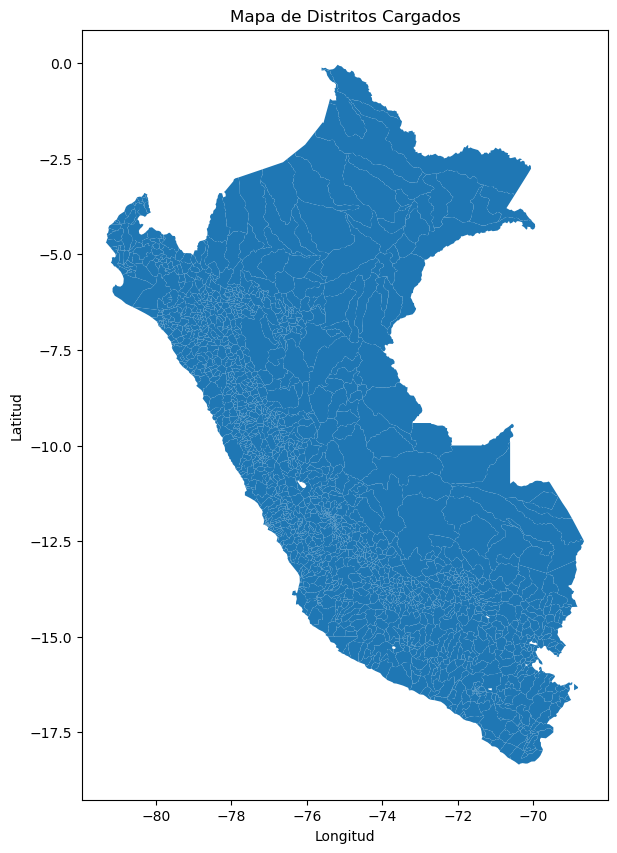

In [9]:
import matplotlib.pyplot as plt

print("\n--- Paso 2: Limpieza y Unión de Fuentes de Datos ---")

# --- 1. Estandarizar el GeoDataFrame ---
# La columna 'IDDIST' en el GeoJSON parece ser el UBIGEO. La renombramos.
if 'IDDIST' in gdf_distritos.columns:
    gdf_distritos.rename(columns={'IDDIST': 'UBIGEO'}, inplace=True)
    
    # Aseguramos que el tipo de dato sea texto (str) y tenga 6 dígitos
    gdf_distritos['UBIGEO'] = gdf_distritos['UBIGEO'].astype(str).str.zfill(6)
    print("Columna de UBIGEO estandarizada en el GeoDataFrame.")
else:
    print("Advertencia: No se encontró la columna 'IDDIST' en el GeoJSON.")

# Seleccionamos solo las columnas que necesitamos del GeoJSON: UBIGEO y la geometría
gdf_geom = gdf_distritos[['UBIGEO', 'geometry']]

# --- 2. Realizar la Unión (Merge) ---
# Unimos el GeoDataFrame de geometrías con nuestro DataFrame maestro de UBIGEOs
# Usamos un 'inner merge' para quedarnos solo con los distritos presentes en ambos archivos
gdf_maestro = gdf_geom.merge(df_ubigeos, on='UBIGEO', how='inner')

print(f"\nLa unión fue exitosa.")
print(f"El GeoDataFrame maestro contiene {len(gdf_maestro)} distritos con geometría y atributos.")
print("Esto significa que se encontraron coincidencias para estos distritos en ambos archivos.")

# --- 3. Inspección del Resultado ---
print("\nPrimeras filas del GeoDataFrame maestro:")
print(gdf_maestro.head())

print("\nVisualización rápida del mapa para confirmar:")
# El comando .plot() de GeoPandas es una forma simple de visualizar las geometrías
gdf_maestro.plot(figsize=(10, 10))
plt.title("Mapa de Distritos Cargados")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

### **Celda 3 (Revisada y Mejorada): Generación de Vecindad con Índice Espacial**

**Justificación Metodológica:**

Este nuevo enfoque es superior al bucle anterior. Utiliza un **índice espacial (R-tree)**, que es una estructura de datos que permite encontrar de forma extremadamente rápida qué polígonos están cerca unos de otros, evitando comparaciones innecesarias.

1.  **Construir el Índice:** GeoPandas crea un R-tree sobre todas las geometrías.
2.  **`sindex.query()`:** Para cada distrito, le preguntamos al índice: "¿Qué otros polígonos se **intersectan** con tu `boundary` (tu frontera)?".
3.  **Filtrar:** La consulta nos devuelve los candidatos a vecinos. Luego, aplicamos la condición `.touches()` solo a este pequeño subconjunto, lo cual es mucho más rápido y estable.

Este método no solo es más rápido, sino que también maneja mejor las posibles geometrías imperfectas.

In [11]:
print("--- Paso 3 (Revisado): Generando la Matriz de Vecindad con Índice Espacial ---")
print("Este método es más rápido y robusto. El proceso puede tardar unos segundos...")

# Creamos una copia para trabajar de forma segura y establecer el índice
gdf_temp = gdf_maestro.copy().set_index('UBIGEO')

# Lista para almacenar los resultados
vecindad_list = []

# Iteramos sobre los UBIGEOs y sus geometrías
for ubigeo, geom in gdf_temp['geometry'].items():
    # Encontramos los vecinos usando el índice espacial.
    # El índice espacial (sindex) devuelve los índices de los polígonos que potencialmente se intersectan.
    # `gdf_temp.sindex.query(geom)` encuentra los candidatos a vecinos.
    # Luego, filtramos esos candidatos con la condición exacta .touches()
    possible_neighbors_indices = gdf_temp.sindex.query(geom, predicate='touches')
    
    # Obtenemos los UBIGEOs de los vecinos reales
    # `possible_neighbors_indices` contiene las posiciones de los vecinos en `gdf_temp`
    # `gdf_temp.index[possible_neighbors_indices]` nos da los UBIGEOs de esas posiciones
    vecinos_ubigeos = gdf_temp.index[possible_neighbors_indices].tolist()

    # Eliminamos el propio distrito de su lista de vecinos si apareciera
    if ubigeo in vecinos_ubigeos:
        vecinos_ubigeos.remove(ubigeo)
        
    # Creamos las tuplas para el resultado final
    for vecino in vecinos_ubigeos:
        vecindad_list.append((ubigeo, vecino))

# Convertimos la lista de tuplas en un DataFrame
df_vecindad = pd.DataFrame(vecindad_list, columns=['UBIGEO', 'UBIGEO_vecino'])

print(f"\n¡Proceso de generación de vecinos completado!")
print(f"Se encontraron un total de {len(df_vecindad)} relaciones de vecindad.")

print("\n--- Primeras 10 filas de la Matriz de Vecindad ---")
print(df_vecindad.head(10))

print("\nInformación del DataFrame de Vecindad:")
df_vecindad.info()

--- Paso 3 (Revisado): Generando la Matriz de Vecindad con Índice Espacial ---
Este método es más rápido y robusto. El proceso puede tardar unos segundos...

¡Proceso de generación de vecinos completado!
Se encontraron un total de 10728 relaciones de vecindad.

--- Primeras 10 filas de la Matriz de Vecindad ---
   UBIGEO UBIGEO_vecino
0  230110        230101
1  230110        230108
2  230108        230101
3  230108        230110
4  230108        230103
5  230108        230104
6  230108        230102
7  230108        230106
8  230108        230107
9  230103        230108

Información del DataFrame de Vecindad:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10728 entries, 0 to 10727
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UBIGEO         10728 non-null  object
 1   UBIGEO_vecino  10728 non-null  object
dtypes: object(2)
memory usage: 167.8+ KB


Para realizar cálculos geométricos precisos como la obtención de un centroide, es una práctica estándar en los Sistemas de Información Geográfica (SIG) trabajar en un Sistema de Coordenadas Proyectadas (Projected CRS) en lugar de uno Geográfico (grados). En esta celda corregida, transformaremos temporalmente la geometría de nuestro distrito a un CRS proyectado común (EPSG:3857, usado por la mayoría de los mapas web) para calcular su centroide con precisión. Luego, revertiremos la proyección de ese punto central a sus coordenadas de latitud/longitud originales para que pueda ser utilizado por Folium, asegurando así la robustez y corrección de nuestro código.

In [13]:
import folium

print("--- Paso 4: Visualización Interactiva de Vecinos ---")

# --- 1. Selecciona un Distrito de Ejemplo ---
distrito_ejemplo_nombre = 'CHACHAPOYAS'

try:
    # Obtenemos el UBIGEO del distrito de ejemplo
    # Aseguramos que la columna 'distrito' también esté en mayúsculas para la comparación
    gdf_maestro['distrito'] = gdf_maestro['distrito'].str.upper()
    ubigeo_ejemplo = gdf_maestro[gdf_maestro['distrito'] == distrito_ejemplo_nombre]['UBIGEO'].iloc[0]

    # --- 2. Encuentra a sus Vecinos ---
    vecinos_del_ejemplo = df_vecindad[df_vecindad['UBIGEO'] == ubigeo_ejemplo]['UBIGEO_vecino'].tolist()
    print(f"El distrito '{distrito_ejemplo_nombre}' (UBIGEO: {ubigeo_ejemplo}) tiene {len(vecinos_del_ejemplo)} vecinos.")

    # --- 3. Prepara los Datos para el Mapa ---
    gdf_ejemplo = gdf_maestro[gdf_maestro['UBIGEO'] == ubigeo_ejemplo]
    gdf_vecinos = gdf_maestro[gdf_maestro['UBIGEO'].isin(vecinos_del_ejemplo)]

    # --- 4. Crea el Mapa Interactivo con Folium (CORREGIDO) ---
    # Para calcular el centroide correctamente, primero proyectamos a un CRS plano (EPSG:3857)
    gdf_ejemplo_proj = gdf_ejemplo.to_crs(epsg=3857)
    centroid_proj = gdf_ejemplo_proj.geometry.centroid
    # Luego, re-proyectamos el punto del centroide de vuelta al CRS original (lat/lon)
    centroid_geo = centroid_proj.to_crs(gdf_ejemplo.crs).iloc[0]
    
    map_center = [centroid_geo.y, centroid_geo.x]
    
    m = folium.Map(location=map_center, zoom_start=9)

    # Añadimos los polígonos de los vecinos en color azul
    folium.GeoJson(
        gdf_vecinos,
        style_function=lambda feature: {'fillColor': 'blue', 'color': 'black', 'weight': 1, 'fillOpacity': 0.6},
        tooltip=folium.GeoJsonTooltip(fields=['distrito'], aliases=['Vecino:'])
    ).add_to(m)

    # Añadimos el polígono del distrito principal en color rojo
    folium.GeoJson(
        gdf_ejemplo,
        style_function=lambda feature: {'fillColor': 'red', 'color': 'black', 'weight': 2, 'fillOpacity': 0.8},
        tooltip=folium.GeoJsonTooltip(fields=['distrito'], aliases=['Distrito Principal:'])
    ).add_to(m)

    print("\nMapa interactivo generado. Se mostrará a continuación.")
    display(m)

except IndexError:
    print(f"Error: No se pudo encontrar el distrito '{distrito_ejemplo_nombre}'. Asegúrate de que el nombre esté bien escrito y en mayúsculas.")
except Exception as e:
    print(f"Ocurrió un error al generar el mapa: {e}")

--- Paso 4: Visualización Interactiva de Vecinos ---
El distrito 'CHACHAPOYAS' (UBIGEO: 010101) tiene 9 vecinos.

Mapa interactivo generado. Se mostrará a continuación.


### **Celda 5: Guardado Final de la Matriz de Vecindad**

**Justificación Metodológica:**

El objetivo final de este notebook es producir un artefacto de datos reutilizable. Guardaremos el DataFrame `df_vecindad` en un formato estándar y portátil como CSV. Este archivo servirá como una "tabla de consulta" (*lookup table*) en nuestros futuros pipelines de modelado, permitiéndonos incorporar rápidamente la información espacial sin tener que recalcularla cada vez, lo cual es una práctica eficiente y modular.

In [14]:
print("\n--- Paso 5: Guardando la Matriz de Vecindad ---")

# Definimos la ruta de salida
output_path = '../buscando_data/Ubigeos_dataset/matriz_vecindad_distrital.csv'

try:
    # Guardamos el DataFrame en formato CSV, sin el índice de pandas
    df_vecindad.to_csv(output_path, index=False)
    print(f"\n¡Éxito!")
    print(f"La matriz de vecindad ha sido guardada en: '{output_path}'")
    print(f"Este archivo contiene {len(df_vecindad)} filas y es el resultado final de este notebook.")
except Exception as e:
    print(f"Ocurrió un error al guardar el archivo: {e}")


--- Paso 5: Guardando la Matriz de Vecindad ---

¡Éxito!
La matriz de vecindad ha sido guardada en: '../buscando_data/Ubigeos_dataset/matriz_vecindad_distrital.csv'
Este archivo contiene 10728 filas y es el resultado final de este notebook.
